# Basic examples

In this notebook we will show how to fit a model to data, in the **desilike** framework.
You need to have installed **desilike** with:
```
python -m pip install git+https://github.com/cosmodesi/desilike#egg=desilike
```
For the analytic solver:
```
python -m pip install jax[cpu]
```

## Model
Let us define a simple, affine model.

In [1]:
from desilike.base import BaseCalculator


class AffineModel(BaseCalculator):  # all calculators should inherit from BaseCalculator

    # Model parameters; those can also be declared in a yaml file
    _params = {'a': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}},
               'b': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}}}
    
    def initialize(self, x=None):
        # Actual, non-trivial initialization must happen in initialize(); this is to be able to do AffineModel(x=...)
        # without doing any actual work
        self.x = x
    
    def calculate(self, a=0., b=0.):
        self.y = a * self.x + b  # simple, affine model
    
    # Not mandatory, this is to return something in particular after calculate (else this will just be the instance)
    def get(self):
        return self.y
    
    # This is only needed for emulation
    def __getstate__(self):
        return {'x': self.x, 'y': self.y}  # dictionary of Python base types and numpy arrays

## Likelihood

Let us define our Gaussian likelihood.

In [2]:
import numpy as np

from desilike.likelihoods import BaseGaussianLikelihood


class Likelihood(BaseGaussianLikelihood):
    
    def initialize(self, theory=None):
        # Let us generate some fake data
        self.xdata = np.linspace(0., 1., 10)
        mean = np.zeros_like(self.xdata)
        self.covariance = np.eye(len(self.xdata))
        rng = np.random.RandomState(seed=42)
        y = rng.multivariate_normal(mean, self.covariance)
        super(Likelihood, self).initialize(y, covariance=self.covariance)
        # Requirements
        # AffineModel will be instantied with AffineModel(x=self.xdata)
        if theory is None:
            theory = AffineModel()
        self.theory = theory
        self.theory.update(x=self.xdata)  # we set x-coordinates, they will be passed to AffineModel's initialize
    
    @property
    def flattheory(self):
        # Requirements (theory, requested in __init__) are accessed through .name
        # The pipeline will make sure theory.run(a=..., b=...) has been called
        return self.theory.y  # data - model

## Pipeline
Let us initialize our likelihood pipeline, that connects the theory and the likelihood.

In [3]:
from desilike import setup_logging

setup_logging()  # set up logging

likelihood = Likelihood()
likelihood.runtime_info.pipeline.calculators

[AffineModel, Likelihood]

In [4]:
# One can evaluate the model directly with:
model = likelihood.theory
y = model(a=1., b=2.)

# One can also evaluate the likelihood directly
loglikelihood = likelihood(a=1., b=2.)
print('Loglikelihood is {:.3f}'.format(loglikelihood))
# The model hasn't be rerun because it has just been run with these parameters
assert id(likelihood.theory.y) == id(y)

loglikelihood = likelihood(a=1., b=1.)
# The model has been run for this new set of parameters
assert id(likelihood.theory.y) != id(y)

# Parameters of a given calculator, can be updated through
model.params = {'a': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 2.}},
                'b': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 2.}}}
fn = '_tests/params.yaml'
# Writing file with parameters fn
from desilike.io import BaseConfig
BaseConfig({'a': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 1.}},
            'b': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 1.}}}).write(fn)
with open(fn, 'r') as file: print(file.read())
model.params = fn
print(model.params)

# One can update all the likelihood parameters as
likelihood.all_params['b'].update(prior={'dist': 'norm', 'loc': 0., 'scale': 100.})
assert likelihood.varied_params['b'].prior.scale == 100.
# Or update e.g. the prior of parameters that start with 'a'
likelihood.all_params = {'a*': {'prior': {'dist': 'norm', 'loc': 0., 'scale': 2.}}}
assert all(param.prior.scale == 2. for param in likelihood.varied_params.select(name='a*'))
# Or set params from file
# Just writing file with parameters fn
from desilike.io import BaseConfig
BaseConfig({'*': {'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}}}).write(fn)
with open(fn, 'r') as file: print(file.read())
likelihood.all_params = fn
assert all(param.prior.scale == 10. for param in likelihood.varied_params.select(name='a*'))

[000000.05] [0/1] 01-05 14:20  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000000.05] [0/1] 01-05 14:20  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.05] [0/1] 01-05 14:20  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.05] [0/1] 01-05 14:20  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000000.05] [0/1] 01-05 14:20  absl                      WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Loglikelihood is -23.977
[000000.15] [0/1] 01-05 14:20  BaseConfig                INFO     Saving _tests/params.yaml.
a:
  prior:
    dist: norm
    loc: 0.0
    scale: 1.0
  value

In [5]:
# If you wish to use your own profiler / sampler, that hasn't be wrapped into desilike (yet)
# just use the likelihood above as a function, and parameters to be varied are:
print('Parameters to be varied are {}.'.format(likelihood.varied_params.names()))
# Some initial values can be obtained through [param.ref.sample() for param in likelihood.varied_params]
# Prior for a given parameter is param.prior(x)

# If you wish to take advantage of the least-square nature of the problem, e.g. with scipy.optimize.curve_fit
from scipy import optimize
names = likelihood.varied_params.names()

def f(x, *params):
    return model(**dict(zip(names, params)))

xdata = np.ones_like(likelihood.flatdata)
ydata = likelihood.flatdata
p0 = [param.value for param in likelihood.varied_params]
sigma = likelihood.covariance
popt, pcov = optimize.curve_fit(f, xdata, ydata, p0=p0, sigma=sigma)[:2]
print('Best-fit parameters are: {}.'.format(popt))

Parameters to be varied are ['a', 'b'].
Best-fit parameters are: [-0.06210334  0.47911278].


## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [6]:
from desilike.profilers import MinuitProfiler

# If iminuit is not installed, you can do:
# from desilike import Installer
# installer = Installer(user=True)  # to install in you user's directory
# installer(MinuitProfiler)

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiler.maximize(niterations=5)

[000000.25] [0/1] 01-05 14:20  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].


In [7]:
profiles = profiler.profiles
# Quantities can be accessed through:
print(profiles.bestfit['a'])

# Save/load example
import os
import tempfile
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    profiles.save(fn)
    from desilike.samples import Profiles
    profiles = Profiles.load(fn)

print(profiles.to_stats(tablefmt='pretty'))

[-0.05917982 -0.05917982 -0.05917982 -0.05917982 -0.05917982]
[000000.97] [0/1] 01-05 14:20  Profiles                  INFO     Saving /tmp/tmp0i4_7v3b/tmp.npy.
[000000.98] [0/1] 01-05 14:20  Profiles                  INFO     Loading /tmp/tmp0i4_7v3b/tmp.npy.
+-------------+--------+---------+-------+
| chi2 = 4.70 | varied | bestfit | error |
+-------------+--------+---------+-------+
|      a      |  True  |  -0.06  | 0.98  |
|      b      |  True  |  0.48   | 0.58  |
+-------------+--------+---------+-------+


array([<AxesSubplot:ylabel='a'>, <AxesSubplot:ylabel='b'>], dtype=object)

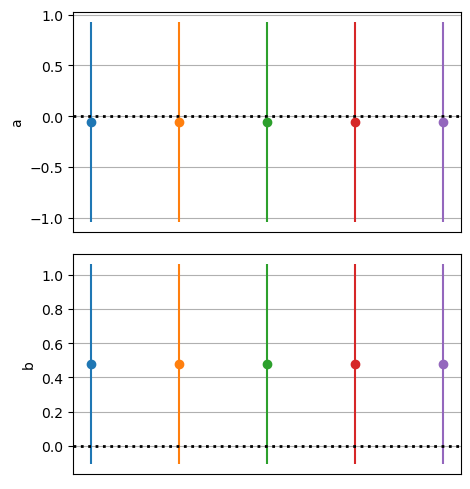

In [8]:
from desilike.samples import plotting
# Compare different best fits: all good, no convergence issues!
plotting.plot_aligned_stacked(profiles, truths=[0., 0.])

In [9]:
# Compute \Delta \chi^{2} = cl^2 = 1 interval for the best best of above best fits
profiler.interval(cl=1)
# Interval can be accessed through
profiler.profiles.interval['a']
print(profiler.profiles.to_stats(tablefmt='latex_raw'))

\begin{tabular}{lllll}
\hline
 $\chi^{2} = 4.70$   & varied   & bestfit   & error   & interval             \\
\hline
 a                   & True     & $-0.06$   & $0.98$  & ${}_{-0.98}^{+0.98}$ \\
 b                   & True     & $0.48$    & $0.58$  & ${}_{-0.58}^{+0.58}$ \\
\hline
\end{tabular}


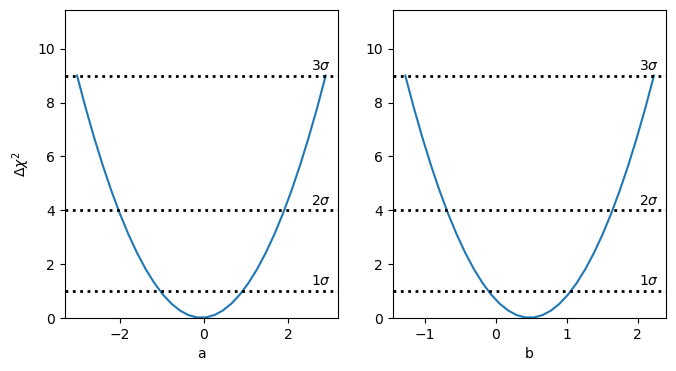

In [10]:
# Profile posterior up to cl = 3 sigmas
profiler.profile(cl=3)
# And plot, subtracting \chi^{2} at best fit
plotting.plot_profile(profiler.profiles, offsets=-2 * profiler.profiles.bestfit.logposterior.max())

## Analytic solver
If jax is installed (maybe we will provide an alterative relying on numpy only?), one can perform analytic marginalization over the parameters for which the model is linear.

In [11]:
from desilike.jax import numpy as jnp  # jax.numpy
from matplotlib import pyplot as plt


class AffineModelJax(AffineModel):  # all calculators should inherit from BaseCalculator (or another calculator)

    def initialize(self, x=None):
        self.x = jnp.array(x)


class LikelihoodWithPlot(Likelihood):

    # Just add a plotting routine
    def plot(self):
        ax = plt.gca()
        ax.errorbar(self.xdata, self.flatdata, yerr=np.diag(self.covariance)**0.5, color='k', linestyle='none', marker='o', label='data')
        ax.plot(self.xdata, self.flattheory, color='r', label='theory')
        ax.grid()
        ax.legend()
        return ax

    
model = AffineModelJax()
# Specify we want to analytical solve for parameter 'b'
# 'derived' can be '.best' (fixed to best fit), '.marg' (analytic marginalization)
# or '.auto', which will be '.best' in case of likelihood profiling, '.marg' in case of sampling
model.params['b'].update(derived='.auto')
likelihood = LikelihoodWithPlot(theory=model)

profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiler.maximize(niterations=5)

[000004.45] [0/1] 01-05 14:20  MinuitProfiler            INFO     Varied parameters: ['a'].
[000004.53] [0/1] 01-05 14:20  Differentiation           INFO     Varied parameters: ['a', 'b'].
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.


array([<AxesSubplot:ylabel='a'>], dtype=object)

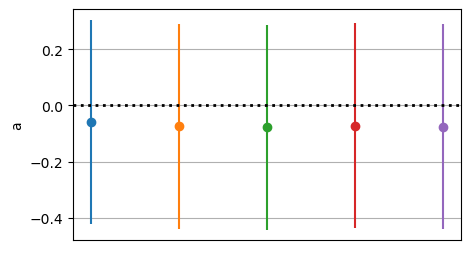

In [12]:
from desilike.samples import plotting
# Compare different best fits: all good, no convergence issues!
plotting.plot_aligned_stacked(profiler.profiles, truths=[0., 0.])

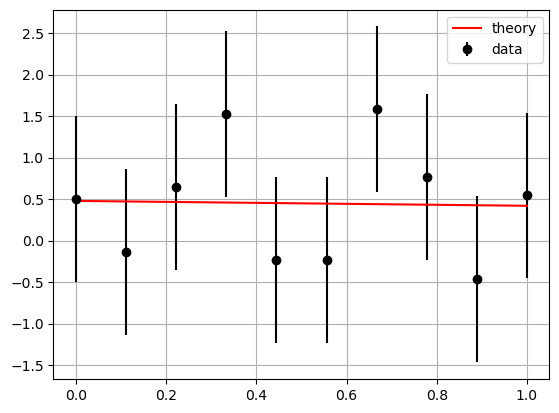

In [13]:
likelihood(**profiler.profiles.bestfit.choice(varied=True))
likelihood.plot()
plt.show()

## Sample
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [14]:
from desilike.samplers import ZeusSampler

# If zeus-mcm is not installed, you can do:
# from desilike import Installer
# installer = Installer(user=True)  # to install in you user's directory
# installer(ZeusSampler)

likelihood = LikelihoodWithPlot()

# By default are running 1 chain
# We can as for me, e.g. chains=2
# MPI processes will be evenly split across all the chains
sampler = ZeusSampler(likelihood, seed=42, nwalkers=10)
# We run samples until convergence, considered reached when Gelman-Rubin (computed over 4 chain subsamples) stabilizes < 0.03; 
sampler.run(check={'max_eigen_gr': 0.03})

[000017.64] [0/1] 01-05 14:20  ZeusSampler               INFO     Varied parameters: ['a', 'b'].
[000017.89] [0/1] 01-05 14:20  root                      INFO     Initialising ensemble of 10 walkers...
[000066.37] [0/1] 01-05 14:21  ZeusSampler               INFO     Diagnostics:
[000066.37] [0/1] 01-05 14:21  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is -0.000636; < 0.03.
[000066.38] [0/1] 01-05 14:21  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is -0.000645.
[000066.39] [0/1] 01-05 14:21  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0819.
[000066.39] [0/1] 01-05 14:21  ZeusSampler               INFO     - max Geweke is 0.324.
[000066.39] [0/1] 01-05 14:21  ZeusSampler               INFO     - Geweke p-value is 0.71.
[000066.40] [0/1] 01-05 14:21  ZeusSampler               INFO     - (150 iterations / integrated autocorrelation time) (reliable) is 55.6.
[000066.43] [0/1] 01-05 14:21  root                    

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000117.28] [0/1] 01-05 14:22  ZeusSampler               INFO     Diagnostics:
[000117.29] [0/1] 01-05 14:22  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0293; < 0.03.
[000117.29] [0/1] 01-05 14:22  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.00488.
[000117.30] [0/1] 01-05 14:22  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0194.
[000117.31] [0/1] 01-05 14:22  ZeusSampler               INFO     - max Geweke is 0.191.
[000117.31] [0/1] 01-05 14:22  ZeusSampler               INFO     - Geweke p-value is 0.332.
[000117.31] [0/1] 01-05 14:22  ZeusSampler               INFO     - (300 iterations / integrated autocorrelation time) (reliable) is 110.
[000117.31] [0/1] 01-05 14:22  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.0294.


In [15]:
# If we want more samples, we can repeat run() calls, e.g.:
sampler.run(max_iterations=200)

[000117.35] [0/1] 01-05 14:22  root                      INFO     Initialising ensemble of 10 walkers...


In [16]:
# Let's remove burnin and get basic stats
chain = sampler.chains[0].remove_burnin(0.5)

# Save/load example
import tempfile
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    chain.save(fn)
    from desilike.samples import Chain
    chain = Chain.load(fn)

print(chain.to_stats(tablefmt='pretty'))

[000154.50] [0/1] 01-05 14:22  Chain                     INFO     Saving /tmp/tmpegg84fzv/tmp.npy.
[000154.50] [0/1] 01-05 14:22  Chain                     INFO     Loading /tmp/tmpegg84fzv/tmp.npy.
+---+--------+-------+--------+------+-----------------+-----------------+
|   | argmax | mean  | median | std  | quantile:1sigma | interval:1sigma |
+---+--------+-------+--------+------+-----------------+-----------------+
| a | -0.04  | -0.01 | -0.01  | 0.96 |   -0.96/+0.95   |   -0.94/+0.96   |
| b |  0.47  | 0.44  |  0.45  | 0.57 |   -0.58/+0.57   |   -0.56/+0.58   |
+---+--------+-------+--------+------+-----------------+-----------------+


[000154.55] [0/1] 01-05 14:22  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
4000 (400, 10)
Removed no burn in


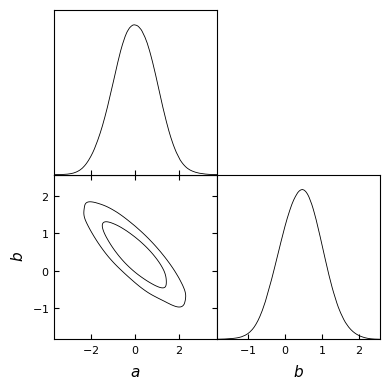

In [17]:
# This actually uses GetDist
# chain.to_getdist() will return a getdist.MCSamples object to play further
plotting.plot_triangle(chain)

## Emulate
If our model took a lot of time to run, we would likely want to build an emulator for it. Let us try this on this simple model.

False
[000154.95] [0/1] 01-05 14:22  Emulator                  INFO     Varied parameters: ['a', 'b'].
[000154.95] [0/1] 01-05 14:22  Emulator                  INFO     Found varying ['y'] and fixed ['x'] outputs.
[000155.16] [0/1] 01-05 14:22  Differentiation           INFO     Varied parameters: ['a', 'b'].
[000155.23] [0/1] 01-05 14:22  Differentiation           INFO     Using auto-differentiation for parameter a.
[000155.24] [0/1] 01-05 14:22  Differentiation           INFO     Using auto-differentiation for parameter b.
[000155.31] [0/1] 01-05 14:22  Emulator                  INFO     Diagnostics:
[000155.42] [0/1] 01-05 14:22  Emulator                  INFO     - mse of y is 0 (square root = 0).


[array([<AxesSubplot:ylabel='y'>, <AxesSubplot:ylabel='$\\Delta$ y'>],
       dtype=object)]

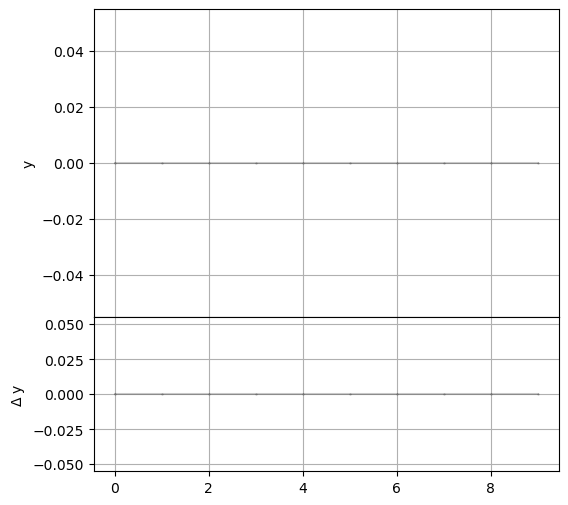

In [18]:
from desilike.emulators import Emulator, EmulatedCalculator, TaylorEmulatorEngine

# Let's take the calculator we want to emulate, i.e. theory (AffineModel)
# Let us perform a Taylor expansion of order 1 for all attributes
# Attributes of AffineModel instance, obtained through theory.__getstate__()
# are automatically split between varied and fixed categories

likelihood = LikelihoodWithPlot()
likelihood()
print(likelihood.theory.params['b'].derived)

emulator = Emulator(likelihood.theory, engine=TaylorEmulatorEngine(order=1))
emulator.set_samples()
emulator.fit()
emulator.check()  # since model is linear, non-zero mse is just due to numerical noise
emulator.plot()  # plot some theory.y samples, and the difference emulator - model at the bottom; all good!

In [19]:
# Now dump the emulator to disk
base_dir = '_tests'
fn = os.path.join(base_dir, 'emulator.npy')
emulator.save(fn)

[000155.61] [0/1] 01-05 14:22  Emulator                  INFO     Saving _tests/emulator.npy.
[000155.61] [0/1] 01-05 14:22  BaseConfig                INFO     Saving _tests/emulator.yaml.


In [20]:
# A yaml file is exported, which helps recollect the parameters of the emulator
# The parameters that have been varied should be specified when using this emulator,
# other parameters (fixed) can be removed if necessary
with open(fn.replace('.npy', '.yaml')) as file:
    print(file.read())

class: AffineModel
info: {}
params:
  a:
    derived: false
    fixed: false
    latex: None
    namespace: ''
    prior:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    proposal: 10.0
    ref:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    shape: []
    value: 0.0
  b:
    derived: false
    fixed: false
    latex: None
    namespace: ''
    prior:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    proposal: 10.0
    ref:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    shape: []
    value: 0.0



In [21]:
# The emulator can be used as replace of the original model
emulator = EmulatedCalculator.load(fn)
assert np.allclose(emulator(a=2., b=1.), model(a=2., b=1.))

[000155.65] [0/1] 01-05 14:22  Emulator                  INFO     Loading _tests/emulator.npy.


In [22]:
# Now let us load our emulator into the pipeline
# Let's just update the likelihood's theory, no need to redefine it
# (Internally the code will reinitialize it)
likelihood.update(theory=emulator)  # or if the emulator is in memory, theory=emulator.to_calculator()

[000155.70] [0/1] 01-05 14:22  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].


array([<AxesSubplot:ylabel='a'>], dtype=object)

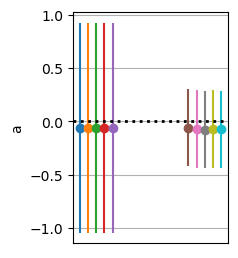

In [23]:
profiler2 = MinuitProfiler(likelihood, seed=42)
profiler2.maximize(niterations=5)
plotting.plot_aligned_stacked([profiler2.profiles, profiler.profiles], truths=True)  # truths=True will get parameter values
# Fits with the emulator and the model are the same, all good!